In [1]:
import os
import json
import pickle
import random
import warnings
import gc

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
from einops import rearrange
from scipy.stats import spearmanr
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.neural_network import MLPRegressor
from tqdm.auto import tqdm
from IPython.display import HTML, display

from baukit import Trace, TraceDict

warnings.filterwarnings("ignore")

In [19]:
SEED = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/scratch/midway3/tzhang3/models/Llama-3.1-8B-Instruct"

### Example inference code

```python
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

# Prepare chat messages
messages = [
    {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
    {"role": "user", "content": "Who are you?"},
]

# Convert messages into a formatted prompt using the tokenizer's chat template
prompt = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True  # adds the assistant tag
)

# Tokenize prompt
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# EOS token setup
eos_token_ids = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")  # safe fallback
]

# Generate response
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=256,
        eos_token_id=eos_token_ids,
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
    )

# Decode output
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Optionally trim the prompt to show just the response
print("\n=== Generated Response ===")
print(generated_text[len(prompt):].strip())
````

---

### Layers

```python
model
```

**Output:**

```shell
LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (head_out): Identity()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_emb): LlamaRotaryEmbedding()
  )
  (lm_head): Linear(in_features=4096, out_features=128256, bias=False)
)
```

---

```python
model.model.layers[0].self_attn
```

**Output:**

```shell
LlamaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (head_out): Identity()
)
```

In [43]:
def model_base_name(model_path):
    return model_path.split("/")[-1].lower()

def load_tokenizer_and_model(model_path, device=None, hf_token=None):
    """
    Loads a tokenizer and model for causal LM generation.
    """
    tokenizer = AutoTokenizer.from_pretrained(
        model_path, use_auth_token=hf_token
    )
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.float16 if device.type == "cuda" else torch.float32,
        low_cpu_mem_usage=True,
        use_auth_token=hf_token
    ).to(device).eval()
    return tokenizer, model


def extract_attention_head_activations(model, prompts, device=None):
    """
    Extracts prefill attention head activations for a list of prompts.
    """
    HEADS = [f"model.layers.{i}.self_attn.head_out" for i in range(model.config.num_hidden_layers)]
    head_wise_hidden_states_list = []

    for prompt in tqdm(prompts, total=len(prompts)):
        with torch.no_grad():
            with TraceDict(model, HEADS) as ret:
                output = model(prompt.to(device))
                head_wise_hidden_states = [ret[head].output.squeeze().detach().cpu() for head in HEADS]
                head_wise_hidden_states = torch.stack(head_wise_hidden_states, dim=0).squeeze().numpy()
                head_wise_hidden_states_list.append(head_wise_hidden_states[:, :, :])

    features = [
        rearrange([states[:, -1, :]], 'b l (h d) -> b l h d', h=model.config.num_attention_heads)
        for states in head_wise_hidden_states_list
    ]
    return np.stack(features, axis=0)


def extract_and_save_features(model, tokenizer, model_path, df_prompts, output_dir="results", prefix="politician", device=None):
    """
    Given a DataFrame with columns ['prompt', 'label'], extract attention features and save to pickle.
    """
    # Tokenize all prompts
    encoded = [tokenizer(p, return_tensors='pt')['input_ids'].to(device) for p in df_prompts['prompt']]
    labels = df_prompts['label'].values

    # Extract features
    features = extract_attention_head_activations(model, encoded, device=device)

    # Save
    base_name = model_base_name(model_path)
    base_dir = os.path.join(output_dir, base_name)
    os.makedirs(base_dir, exist_ok=True)

    out_path = os.path.join(base_dir, f"{prefix}_features.pkl")
    with open(out_path, 'wb') as f:
        pickle.dump((features, labels), f)
    print(f"Saved features to {out_path}")

    return features


def train_ridge_models(
    model,
    model_path,
    data_dir="results",
    prefix="politician",
    alpha=1.0,
    n_splits=2,
    seed=SEED
):
    # Load features and labels
    base_name = model_base_name(model_path)
    data_path = os.path.join(data_dir, base_name, f"{prefix}_features.pkl")
    with open(data_path, 'rb') as f:
        features, labels = pickle.load(f)

    # Initialize containers
    n_layers = model.config.num_hidden_layers
    n_heads = model.config.num_attention_heads
    performance = np.zeros((n_layers, n_heads))
    ridge_dict = {}

    # Train/test per attention head
    for i in tqdm(range(n_layers), desc="Layers"):
        ridge_dict[i] = {}
        for j in range(n_heads):
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
            for train_idx, test_idx in kf.split(range(features.shape[0])):
                X_train = features[train_idx, 0, i, j, :]
                X_test = features[test_idx, 0, i, j, :]
                y_train = np.array(labels)[train_idx]
                y_test = np.array(labels)[test_idx]

                model_ridge = Ridge(alpha=alpha, fit_intercept=False)
                model_ridge.fit(X_train, y_train)
                ridge_dict[i][j] = model_ridge

                y_pred = model_ridge.predict(X_test)
                performance[i, j] += spearmanr(y_test, y_pred).statistic

    # Average across folds
    performance /= n_splits

    # Save results
    base_dir = os.path.join(data_dir, base_name)
    os.makedirs(base_dir, exist_ok=True)
    pickle.dump(performance, open(os.path.join(base_dir, f"{prefix}_performance.pkl"), 'wb'))
    pickle.dump(ridge_dict, open(os.path.join(base_dir, f"{prefix}_ridge.pkl"), 'wb'))

    return performance, ridge_dict


def clean_up(device=None):
    """
    Clean up the model and GPU memory.
    """
    gc.collect()
    if device:
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()


def extract_head_out_per_token(
    model, tokenizer, prompts,
    candidate_answers=None,
    max_new_tokens=32,
    output_only=False,
    device=None):
    """
    Extracts attention head outputs per token and optionally probabilities for candidate answers.

    Args:
        model: HuggingFace transformer model
        tokenizer: Corresponding tokenizer
        prompts: List of prompt strings
        candidate_answers: List of string candidates (e.g., ["1", "2", ..., "7"]) or None
        max_new_tokens: Number of tokens to generate

    Returns:
        List of dictionaries, each with:
            - 'features': np.array (T, L, H, D)
            - 'token_ids': np.array of generated token IDs
            - 'answer': decoded generated string
            - 'candidate_logits': np.array (len(candidate_answers),) if applicable
            - 'candidate_probs': np.array (len(candidate_answers),) if applicable
    """
    num_layers = model.config.num_hidden_layers
    num_heads = model.config.num_attention_heads
    hidden_size = model.config.hidden_size
    head_dim = hidden_size // num_heads

    HEADS = [f"model.layers.{i}.self_attn.head_out" for i in range(num_layers)]

    # Prepare candidate token IDs
    candidate_token_ids = None
    if candidate_answers is not None:
        candidate_token_ids = [tokenizer.convert_tokens_to_ids(ans) for ans in candidate_answers]
        candidate_token_ids = torch.tensor(candidate_token_ids, device=device)

    results = []

    for prompt in tqdm(prompts):
        input_ids = tokenizer(prompt, return_tensors='pt').input_ids.to(device)

        token_outputs_by_layer = [[] for _ in range(num_layers)]

        def make_hook(layer_idx):
            def hook_fn(module, inp, out):
                if output_only:
                    token_outputs_by_layer[layer_idx].append(out.squeeze(0)[-1].detach().cpu())
                else:
                    token_outputs_by_layer[layer_idx].extend(out.squeeze(0).detach().cpu())
            return hook_fn

        # Register hooks
        hooks = []
        for i, name in enumerate(HEADS):
            module = dict(model.named_modules())[name]
            hooks.append(module.register_forward_hook(make_hook(i)))

        # Generate tokens and optionally return scores
        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_ids,
                max_new_tokens=max_new_tokens,
                do_sample=False,
                return_dict_in_generate=True,
                output_scores=(candidate_answers is not None),
                output_attentions=False
            )

        for h in hooks:
            h.remove()

        # Token output
        generated_ids = outputs.sequences.squeeze(0).cpu().numpy()
        decoded = tokenizer.decode(generated_ids, skip_special_tokens=True)

        # Attention head features
        layerwise_outputs = []
        for layer_outputs in token_outputs_by_layer:
            stacked = torch.stack(layer_outputs, dim=0)  # (T, hidden_size)
            reshaped = stacked.view(stacked.size(0), num_heads, head_dim)  # (T, H, D)
            layerwise_outputs.append(reshaped)

        layerwise_outputs = torch.stack(layerwise_outputs, dim=0)  # (L, T, H, D)
        layerwise_outputs = rearrange(layerwise_outputs, 'l t h d -> t l h d')  # (T, L, H, D)

        # Package result
        result = {
            "features": layerwise_outputs.numpy(),  # (T, L, H, D)
            "token_ids": generated_ids,
            "answer": decoded,
        }

        # Extract candidate logits & probs
        if candidate_token_ids is not None and len(outputs.scores) > 0:
            first_step_logits = outputs.scores[0].squeeze(0)  # (vocab_size,)
            probs = F.softmax(first_step_logits, dim=-1)  # (vocab_size,)
            candidate_logits = first_step_logits[candidate_token_ids].cpu().numpy()
            candidate_probs = probs[candidate_token_ids].cpu().numpy()
            result["candidate_logits"] = candidate_logits
            result["candidate_probs"] = candidate_probs

        results.append(result)

    return results


def get_top_indices(performance, k=8):
    # Top-k (i, j) heads
    return np.dstack(np.unravel_index(np.argsort(performance.ravel()), (32, 32)))[0][-k:, :]


def predict_per_token_scores(results, ridge_models, performance, k):
    """
    Predict per-token scores for voter samples with variable-length inputs.

    Args:
        results: List of dictionaries with keys 'features' and 'token_ids'
        models: dict mapping (i,j) -> trained Ridge model
        performance: dict mapping (i,j) -> performance score
        k: int, number of top ridge models to use

    Returns:
        scores: List[np.ndarray] where each element has shape (T,)
    """
    top_indices = get_top_indices(performance, k=k)

    for res in results:  # sample_features: (T, L, H, D)
        sample_features = res['features']  # Shape: (T, L, H, D)
        T, L, H, D = sample_features.shape
        scores = np.zeros(T)

        for t in range(T):
            for i, j in top_indices:
                model = ridge_models[i][j]
                x = sample_features[t, i, j, :]  # Shape: (D,)
                scores[t] += model.predict(x.reshape(1, -1))[0]

        scores /= len(top_indices)
        res['scores'] = scores

    return results


def visualize_token_scores(results, tokenizer, title_prefix="Prompt", vmin=-1.0, vmax=1.0):
    """
    Displays tokens with per-token scores using color-coding.

    Args:
        results (List[Dict]): List of dictionaries with keys 'token_ids' and 'features'.
        scores (np.ndarray): Array of shape (N_prompts, T) with score values per token.
        tokenizer (transformers.PreTrainedTokenizer): HuggingFace tokenizer to decode tokens.
        title_prefix (str): Optional prefix for prompt titles.
    """    
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap('RdBu_r')

    for idx, res in enumerate(results):
        ids = res['token_ids']
        score_arr = res['scores']
        tokens = tokenizer.convert_ids_to_tokens(ids)
        spans = []
        for tok, sc in zip(tokens[1:], score_arr[: len(tokens)]):  # skip BOS token
            color = mpl.colors.to_hex(cmap(norm(sc)))
            safe_tok = (
                tok.replace('&', '&amp;')
                .replace('<', '&lt;')
                .replace('>', '&gt;')
                .replace('Ġ', ' ')  # optional: replace GPT-style space token if BPE
            )
            spans.append(
                f"<span style='background-color:{color};padding:2px;margin:1px;border-radius:3px;color:#313131;'>{safe_tok}</span>"
            )
        html = (
            '<div style="line-height:1.6;font-family:monospace;">'
            + ' '.join(spans)
            + '</div>'
        )
        display(HTML(f"<h4>{title_prefix} {idx + 1}:</h4>{html}"))
        

def plot_candidate_probabilities(results, candidate_answers, title_prefix="Prompt", figsize=(8, 4)):
    """
    Visualizes the candidate probability distributions for each prompt result.

    Args:
        results: List of result dictionaries returned by extract_head_out_per_token
        candidate_answers: List of string labels corresponding to candidate tokens
        title_prefix: Prefix used in subplot titles (e.g., "Prompt 1", "Prompt 2", ...)
        figsize: Size of each subplot figure
    """
    num_plots = len(results)

    for idx, result in enumerate(results):
        if "candidate_probs" not in result:
            print(f"Skipping prompt {idx+1}: no candidate_probs found.")
            continue

        probs = result["candidate_probs"]
        decoded_answer = result["answer"]

        plt.figure(figsize=figsize)
        bars = plt.bar(candidate_answers, probs)

        plt.title(f"{title_prefix} {idx + 1}")
        plt.ylabel("Probability")
        plt.ylim(0, 1)
        plt.xticks(rotation=0)

        # Annotate bar values
        for bar, prob in zip(bars, probs):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                     f"{prob:.2f}", ha="center", va="bottom", fontsize=9)

        plt.tight_layout()
        plt.show()


def load_ridge_models(ridge_prefix):
    """
    Load ridge models and performance scores.

    Args:
        ridge_prefix (str): Prefix for the ridge model files.
        k (int): Number of top ridge models to load.

    Returns:
        tuple: Tuple containing the loaded ridge models and performance scores.
    """
    performances = pickle.load(open(f"./results/{ridge_prefix}_performance.pkl", 'rb'))
    ridge_models = pickle.load(open(f"./results/{ridge_prefix}_ridge.pkl", 'rb'))
    
    return ridge_models, performances


def generate_and_score_tokens(
    model_path,
    prompts,
    model=None,
    tokenizer=None,
    max_new_tokens=512,
    hf_token=None,
    k=8,
    candidate_answers=None,
    output_only=False,
    ridge_prefix=None,
    device=None
):
    """
    Generate and visualize token-level bias scores for a list of prompts.

    Args:
        model_path (str): Name of the HuggingFace model.
        prompts (List[str]): List of user prompts.
        max_new_tokens (int): Max tokens to generate during inference.
        hf_token (str): HuggingFace token if authentication is needed.
        k (int): Number of top ridge models to use.
    """
    delete_model = False
    
    if model and tokenizer:
        model.to(device)
    else:
        tokenizer, model = load_tokenizer_and_model(model_path, device=device, hf_token=hf_token)
        delete_model = True

    # Step 1: Extract features
    results = extract_head_out_per_token(
        model, tokenizer, prompts,
        max_new_tokens=max_new_tokens,
        candidate_answers=candidate_answers,
        output_only=output_only,
        device=device
    )

    # Step 2: Load ridge models and performance scores
    if ridge_prefix is None:
        ridge_prefix = f"{model_base_name(model_path)}/politician"
    ridge_models, performances = load_ridge_models(ridge_prefix)

    # Step 4: Predict token-level scores
    results = predict_per_token_scores(results, ridge_models, performances, k)

    if delete_model:
        del model
        del tokenizer
        gc.collect()
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        
    return results

In [14]:
tokenizer, model = load_tokenizer_and_model(model_path, device=device)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## Data

In [26]:
df = pd.read_csv('./data/HS116_members.csv')
df = df.loc[pd.notnull(df.nominate_dim1)].reset_index(drop=True)
df['first_middle_name'] = df['bioname'].apply(lambda x: x.split(', ')[1])
df['first_name'] = df['first_middle_name'].apply(lambda x: x.split(' ')[0] + ' ' if ' ' in x else x + ' ')
df['middle_name'] = df['first_middle_name'].apply(lambda x: x.split(' ')[1][0] + '. ' if ' ' in x else '')
df['last_name'] = df['bioname'].apply(lambda x: x.split(', ')[0].lower().capitalize().strip())
df['fullname'] = df['first_name'] + df['middle_name'] + df['last_name']

In [27]:
adfontesmedia = pd.read_csv('./data/adfontesmedia.csv')

In [38]:
def build_politician_prompt(fullname: str) -> str:
    return (
        f"USER: Generate a statement by {fullname}, a politician in the United States.\n"
        f"ASSISTANT: In 2019, {fullname} said that"
    )

def build_news_prompt(source_name: str) -> str:
    return (
        f"USER: Generate a statement from a news source in the United States.\n"
        f"ASSISTANT: {source_name} reported that"
    )

# Generate prompts
prompts_politicians = df["fullname"].apply(build_politician_prompt)
labels = df["nominate_dim1"].astype(float).values
df_prompts_politicians = pd.DataFrame({"prompt": prompts_politicians, "label": labels})

prompts_news = adfontesmedia["moniker_name"].apply(build_news_prompt)
labels = adfontesmedia["bias_mean"].astype(float).values
df_prompts_news = pd.DataFrame({"prompt": prompts_news, "label": labels})

In [28]:
df_anes = pd.read_csv("data/anes.csv")

# Prompt builder
def build_prompt(persona, query):
    return (
        f"USER: How would {persona} in the United States in 2019 answer the following question. "
        f"{query.strip()} "
        f"ASSISTANT: As {persona}, I would answer the question with a score of "
    )

prompts_anes = []
for _, row in df_anes.iterrows():
    domain, question = row['domain'], row['query']
    for persona in df['fullname'].tolist():
        prompts_anes.append(build_prompt(persona, question))

In [29]:
# Prompt builder
def build_prompt(alignment, query):
    return (
        f"USER: Generate a statement from the {alignment} on the following question in the United States. "
        # f"{query.strip()}\n"
        # f"Do you favor or oppose transgender bathrooms?\n"
        # f"Do you favor or oppose US military aid to Ukraine?\n"
        f"Do you favor or oppose buying green socks for Christmas?\n"
        f"ASSISTANT: In 2019, the {alignment} believes that"
    )
    
prompts_socks = []
for alignment in ["liberal", "conservative"]:
    prompts_socks.append(build_prompt(alignment, None))

In [30]:
def build_prompt(query):
    return (
        f"USER: In the context of 2019 U.S. politics, is the following statement biased and leaning toward a liberal or conservative viewpoint? "
        f"{query.strip()}\n"
        f"ASSISTANT: The statement is"
    )

df_bias = pd.read_csv("data/policy_statements.csv")

prompts_bias = []
for _, row in df_bias.iterrows():
    text = row['response']
    prompts_bias.append(build_prompt(text))


In [31]:
def build_vote_prompts(alignment):
    return [
        f"USER: If you had to vote in the 2019 U.S. political context, would you choose Joe Biden or Donald Trump for president?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: In your opinion, who would be the better choice for the next U.S. president in 2020—Biden or Trump?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: In the 2019 U.S. political environment, who aligns more with your values—Joe Biden or Donald Trump?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Given the candidates Joe Biden and Donald Trump, who would you vote for in the 2020 U.S. election?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Based on 2019 U.S. politics, which candidate would receive your vote: Donald Trump or Joe Biden?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: As a {alignment}, who would you feel more comfortable voting for in the 2020 U.S. presidential election—Joe Biden or Donald Trump?\nASSISTANT: I would vote for",
        f"USER: In 2019, which presidential candidate—Trump or Biden—better represents your political beliefs as a {alignment}?\nASSISTANT: I would vote for",
        f"USER: Considering your political stance as a {alignment}, who would you support in the 2020 U.S. presidential race?\nASSISTANT: I would vote for",
        f"USER: Reflecting on 2019 U.S. politics, who would a {alignment} likely cast their vote for: Joe Biden or Donald Trump?\nASSISTANT: I would vote for",
        f"USER: As a politically {alignment} person in the 2019 United States, which candidate would you trust more to lead the country—Biden or Trump?\nASSISTANT: I would vote for"
    ]

prompts_vote = []
meta_vote = []

for alignment in ["liberal", "conservative"]:
    for prompt in build_vote_prompts(alignment):
        prompts_vote.append(prompt)
        meta_vote.append({"alignment": alignment})


In [32]:
def build_prompt(query):
    return (
        f"USER: In the context of 2019 U.S. politics, please rewrite the following statement to make it politically neutral and free from liberal or conservative bias:\n"
        f"\"{query.strip()}\"\n"
        f"ASSISTANT: Here's a neutral version of the text:"
    )

df_bias = pd.read_csv("data/policy_statements.csv")

prompts_rewrite = []
meta_rewrite = []
for _, row in df_bias.sample(1, random_state=42).iterrows():
    text = row['response']
    prompts_rewrite.append(build_prompt(text))
    meta_rewrite.append({"name": row["name"], "domain": row["domain"]})

## Probing

In [44]:
features = extract_and_save_features(
    model,
    tokenizer,
    model_path,
    df_prompts_politicians,
    device=device,
)

  0%|          | 0/552 [00:00<?, ?it/s]

Saved features to results/llama-3.1-8b-instruct/politician_features.pkl


In [46]:
performance, ridge_models = train_ridge_models(
    model,
    model_path,
    data_dir="results",
    prefix="politician",
    alpha=1.0,
    n_splits=2,
    seed=SEED
)

Layers:   0%|          | 0/32 [00:00<?, ?it/s]

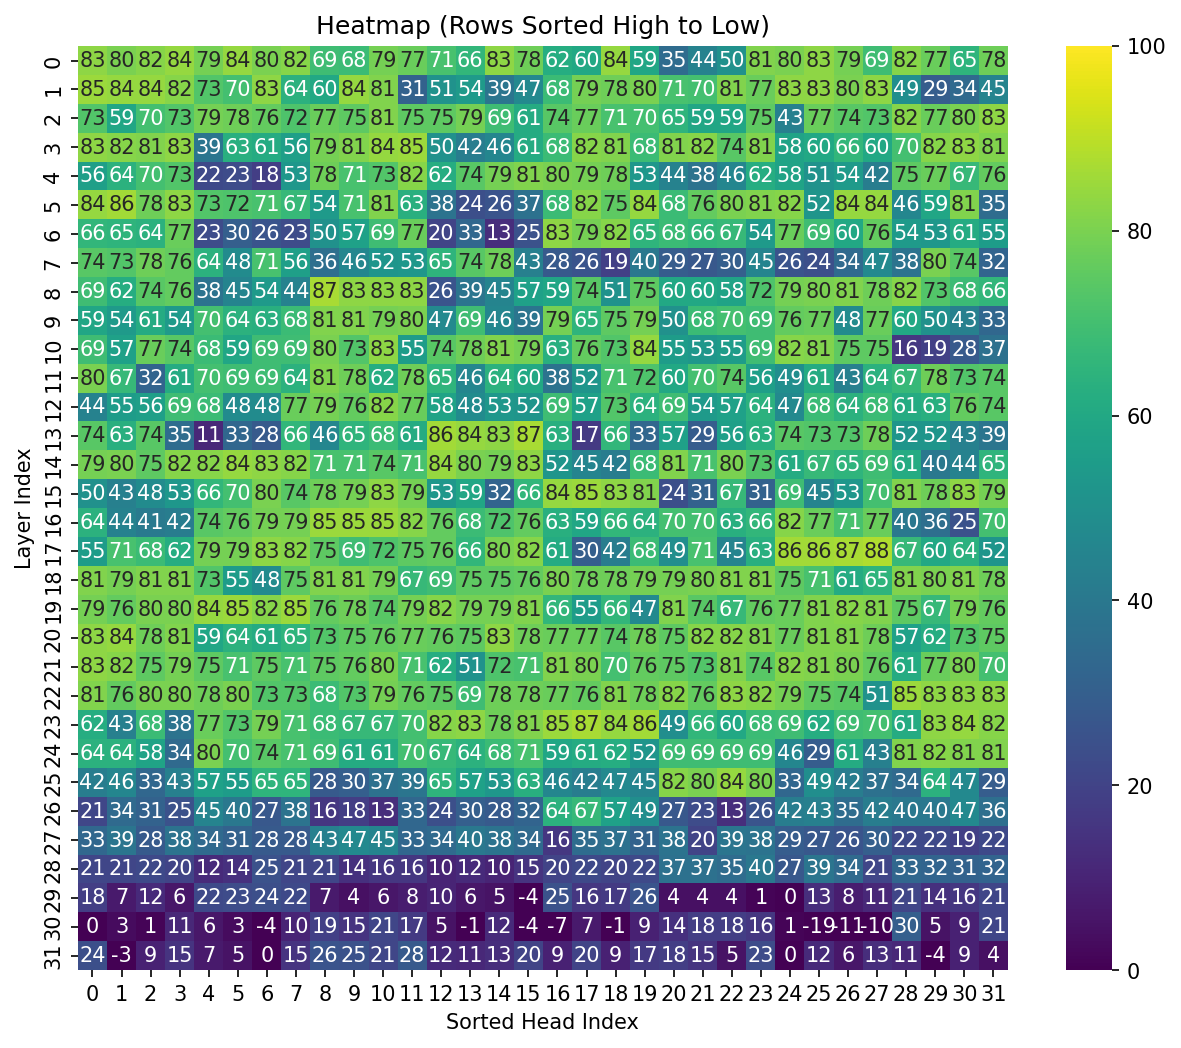

In [60]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sort each row from high to low
performance_temp = (performance * 100).astype(int)
# performance_temp = -np.sort(-performance_temp, axis=1)  # or use: np.sort(performance * -1, axis=1) * -1
performance_temp = np.flipud(performance_temp)

plt.figure(figsize=(10, 8), dpi=150)
sns.heatmap(performance_temp, annot=True, cmap='viridis', cbar=True, vmin=0, vmax=100)
plt.title('Heatmap (Rows Sorted High to Low)')
plt.xlabel('Sorted Head Index')
plt.ylabel('Layer Index')
plt.show()
